# Age regression task to benchmark multicentric methods

After performing harmonization using the different methods on the state-of-the-art, we end up with the following list of files:

- `harmonized (SGD-ComBat MLP).csv`
- `harmonized_cVAE.csv`
- `harmonized (SGD-ComBat Linear).csv`
- `harmonized (d-ComBat-GAM).csv`
- `harmonized (Fed-ComBat MLP).csv`
- `harmonized (NeuroComBat).csv`
- `harmonized (d-ComBat).csv`
- `harmonized (Fed-ComBat Linear).csv`
- `harmonized (ComBat-GAM).csv`
- `non_harmonized_data.csv`

The goal now is to evaluate the efficacy of each bu evaluating how good these methods are at predicting age. We will use the `non_harmonized_data.csv` as the baseline (non-harmonized data) and compare the performance of each method against it percentually in terms of regression performance.

In [1]:
import os

# root_dir = '/Users/ssilvari/Downloads/fedcombat_real_data/unified copy best MLP'
root_dir = '/Users/ssilvari/Downloads/BHBChallenge'
files = [
    'non_harmonized_data.csv',
     'harmonized_cVAE.csv',
     'harmonized (ComBat-GAM).csv',
     'harmonized (d-ComBat-GAM).csv',
     'harmonized (d-ComBat).csv',
     'harmonized (Fed-ComBat Linear).csv',
     'harmonized (Fed-ComBat MLP).csv',
     'harmonized (NeuroComBat).csv',
     'harmonized (SGD-ComBat Linear).csv',
     'harmonized (SGD-ComBat MLP).csv'
]

files = [os.path.join(root_dir, f) for f in files if os.path.isfile(os.path.join(root_dir, f))]
print(files)

['/Users/ssilvari/Downloads/BHBChallenge/non_harmonized_data.csv', '/Users/ssilvari/Downloads/BHBChallenge/harmonized (ComBat-GAM).csv', '/Users/ssilvari/Downloads/BHBChallenge/harmonized (d-ComBat-GAM).csv', '/Users/ssilvari/Downloads/BHBChallenge/harmonized (d-ComBat).csv', '/Users/ssilvari/Downloads/BHBChallenge/harmonized (Fed-ComBat Linear).csv', '/Users/ssilvari/Downloads/BHBChallenge/harmonized (Fed-ComBat MLP).csv', '/Users/ssilvari/Downloads/BHBChallenge/harmonized (NeuroComBat).csv', '/Users/ssilvari/Downloads/BHBChallenge/harmonized (SGD-ComBat Linear).csv', '/Users/ssilvari/Downloads/BHBChallenge/harmonized (SGD-ComBat MLP).csv']


Define a function to read the data and return the `X` and `y` matrices.

In [2]:
import pandas as pd
import numpy as np

def read_data(file):
    df = pd.read_csv(file, index_col=0) #.reset_index(drop=True)

    # Filter DX == 'CN' and Sex = 'Male'
    try:
        df = df[(df['DX'] == 'CN') & (df['Sex'] == 'Male')]
    except:
        df = df[df['Sex'].str.lower() == 'male']

    # Remove undesired columns: `site` and `DX`
    df = df.drop(columns=['DX', 'Sex'], errors='ignore')

    # Remove rows with NaNs
    df = df.dropna()

    # Phenotypes of interest
    phenotypes = [
        'Right-Hippocampus',
        'Left-VentralDC',
        'rh_rostralmiddlefrontal_thickness',
        'eTIV'
    ]

    # Extract classification variables of interest
    X = df.drop(columns=['Age', 'site'])#[phenotypes]
    site = df['site'].apply(str).astype('category')
    y = df['Age']

    return X, y, site

# Test function on non-harmonized data
file_non_harmonized = files[0]
assert 'non_harmonized_data.csv' in file_non_harmonized
X, y, site = read_data(file_non_harmonized)
print(X.shape, y.shape)

# Save shapes for future assertions
x_shape = X.shape
y_shape = y.shape

(1669, 476) (1669,)


In [6]:
# Create a function to regress age and return all the regression metrics possible
# The best regression model in the literature is the Random Forest Regressor
# Use k-fold cross-validation to evaluate the performance of the model

from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

# Import dummy regressor
from sklearn.dummy import DummyRegressor

# Create a function that generates the indexes so results are comparable across methods
def generate_indexes(X, y, site, n_splits=5, random_state=42):
    from sklearn.model_selection import StratifiedKFold

    # Stratified KFold
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    indexes = []
    for train_index, test_index in kf.split(X, site):
        indexes.append((train_index, test_index))

    return indexes

def regress_age(X, y, site, indexes, method_name:str, n_estimators=100, max_depth=10, random_state=42):
    metrics = []

    for fold_i, (train_index, test_index) in enumerate(indexes):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Create pipeline
        pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('regressor', RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state))
            # ('regressor', DummyRegressor(strategy='mean'))  # For testing purposes
        ])

        # Fit model
        pipe.fit(X_train, y_train)

        # Predict
        y_pred = pipe.predict(X_test)

        # Save predictions
        df = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})

        df['Method'] = method_name
        df['Site'] = site.iloc[test_index]

        # Calculate errors
        df['Absolute Error'] = np.abs(df['y_test'] - df['y_pred'])
        df['Squared Error'] = np.square(df['y_test'] - df['y_pred'])

        # Calculate metrics and append them to the list `metrics` as dataframes. Save folds as well.
        metrics_dict = {
            'MAE': [mean_absolute_error(y_true=y_test, y_pred=y_pred)],
            'MSE': [mean_squared_error(y_true=y_test, y_pred=y_pred)],
            'R2': [r2_score(y_true=y_test, y_pred=y_pred)],
            'MAPE': [mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred)]
        }
        # Create dataframe from dictionary and append to list
        metrics_df = pd.DataFrame(metrics_dict)
        metrics_df['Method'] = method_name
        metrics_df['Fold'] = fold_i
        metrics.append(metrics_df)

    return df, pd.concat(metrics, ignore_index=True)

# Test function
# Get indexes based on non-harmonized data
# indexes = generate_indexes(X[:100], y[:100], site[:100])
# err_test, metrics_test = regress_age(X[:100], y[:100], site[:100], indexes, method_name='Test')
# print(err_test.sample(5))
# print(metrics_test)

# Generate the actual indexes
indexes = generate_indexes(X, y, site)

In [7]:
# Iterate over all files and perform regression. Concatenate results into a single DataFrame.
import seaborn as sns

metrics = []
errors = []

for file in files:
    method_name = os.path.basename(file).split('.')[0]
    print(f'Regressing age using {method_name}')
    if 'harmonized (ComBat-GAM).csv' in method_name:
        pass

    X, y, site = read_data(file)
    assert len(X) == x_shape[0]
    assert len(y) == y_shape[0]

    errors_df, metrics_df = regress_age(X, y, site, indexes, method_name=method_name)

    errors.append(errors_df)
    metrics.append(metrics_df)

metrics = pd.concat(metrics, ignore_index=True)
errors = pd.concat(errors, ignore_index=True)

Regressing age using non_harmonized_data
Regressing age using harmonized (ComBat-GAM)
Regressing age using harmonized (d-ComBat-GAM)
Regressing age using harmonized (d-ComBat)
Regressing age using harmonized (Fed-ComBat Linear)
Regressing age using harmonized (Fed-ComBat MLP)
Regressing age using harmonized (NeuroComBat)
Regressing age using harmonized (SGD-ComBat Linear)
Regressing age using harmonized (SGD-ComBat MLP)


In [8]:
metrics.head()

,MAE,MSE,R2,MAPE,Method,Fold
0,5.179819,68.591193,0.712758,0.206220,non_harmonized_data,0
1,5.066360,62.312164,0.688839,0.216756,non_harmonized_data,1
2,4.651512,60.879715,0.713188,0.191485,non_harmonized_data,2
3,4.335449,46.944383,0.744519,0.177938,non_harmonized_data,3
4,4.864631,54.124490,0.727289,0.206724,non_harmonized_data,4


                Method Metric     Value
0  non_harmonized_data    MAE  5.179819
1  non_harmonized_data    MAE  5.066360
2  non_harmonized_data    MAE  4.651512
3  non_harmonized_data    MAE  4.335449
4  non_harmonized_data    MAE  4.864631


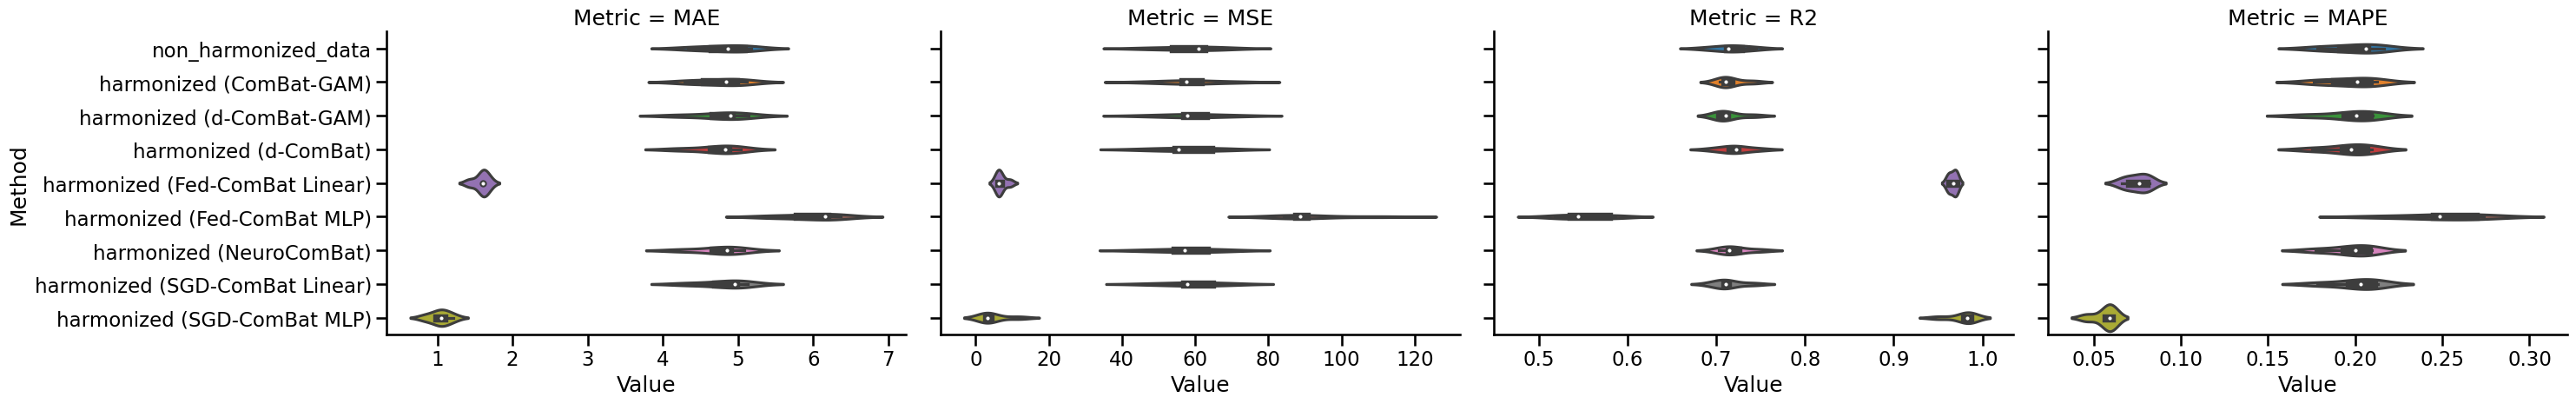

In [9]:
# Plot metrics using catplot. Melt the dataframe and plot each metric separetely (sharey=False).
import matplotlib.pyplot as plt

sns.set_context('talk')
metrics_melted = pd.melt(metrics, id_vars=['Method'], value_vars=['MAE', 'MSE', 'R2', 'MAPE'], var_name='Metric', value_name='Value')
print(metrics_melted.head())

# Set size to be larger
sns.catplot(data=metrics_melted, y='Method', x='Value', kind='violin', sharex=False, col='Metric', height=5, aspect=1.5)
plt.show()

In [12]:
# # Plot metrics using catplot. Melt the dataframe and plot each metric separetely (sharey=False).
# import matplotlib.pyplot as plt
#
# sns.set_context('talk')
# metrics_melted = pd.melt(metrics, id_vars=['Method', 'Site'], value_vars=['Absolute Error', 'Squared Error'], var_name='Metric', value_name='Value')
# print(metrics_melted.head())
#
# # Set size to be larger
# sns.catplot(data=metrics_melted, y='Method', x='Value', kind='violin', sharex=False, col='Metric', height=5, aspect=1.5)
# plt.show()

In [ ]:
# Save classification metrics
csv_file = root_dir + os.sep + 'regression_metrics.csv'
metrics.to_csv(csv_file, index=False)